code from https://www.pyimagesearch.com/2018/12/03/deep-learning-and-medical-image-analysis-with-keras/

# 데이터 준비

구글 드라이브 연동 후 malaria 폴더 안에 준비
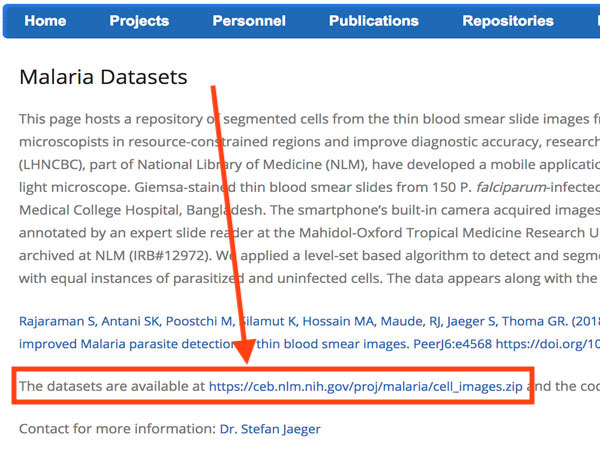

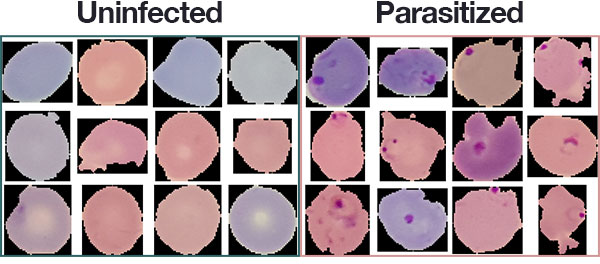

In [23]:
%%shell
pwd
cd '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)'
cd malaria/
pwd

/content
/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/malaria


In [2]:
%%shell
pwd
cd '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)'
rm -rf malaria/
mkdir malaria/
cd malaria/
pwd
wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
unzip cell_images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_91.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102516_cell_104.

tree 를 통한 프로젝트 구조 살펴보기

In [3]:
!sudo apt-get install tree # for Ubuntu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (91.7 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 144676 files and directories currently instal

In [24]:
%%shell
cd '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/malaria'
tree --dirsfirst --filelimit 10

.
├── cell_images
│   ├── Parasitized [13780 entries exceeds filelimit, not opening dir]
│   └── Uninfected [13780 entries exceeds filelimit, not opening dir]
├── testing
│   ├── Parasitized [2726 entries exceeds filelimit, not opening dir]
│   └── Uninfected [2786 entries exceeds filelimit, not opening dir]
├── training
│   ├── Parasitized [9955 entries exceeds filelimit, not opening dir]
│   └── Uninfected [9887 entries exceeds filelimit, not opening dir]
├── validation
│   ├── Parasitized [1098 entries exceeds filelimit, not opening dir]
│   └── Uninfected [1106 entries exceeds filelimit, not opening dir]
└── cell_images.zip

12 directories, 1 file


config.py : 모든 상수 변수를 저장한 파일
- 셀 이미지의 원래 데이터셋의 경로
- 데이터셋 기본 경로
- 출력 훈련, 검증 및 테스트 디렉토리에 대한 경로
- 80% train (80% 중 10%를 validation으로 검증 분할), 20% test

In [25]:
# import the necessary packages
import os

# 이미지의 * original * 입력 디렉토리 경로를 초기화
# initialize the path to the *original* input directory of images
origin_path = '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/'
ORIG_INPUT_DATASET = origin_path + "malaria/cell_images"

# 훈련 및 테스트 분할을 계산한 후 이미지를 포함할 * new * 디렉토리의 기본 경로를 초기화
# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = origin_path + "malaria"

In [26]:
# 교육, 검증 및 테스트 디렉토리
# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

# define the amount of data that will be used training
TRAIN_SPLIT = 0.8

# the amount of validation data will be a percentage of the *training* data
VAL_SPLIT = 0.1

build_dataset.py : 말라리아 세포 이미지 데이터 세트를 훈련, 검증 및 테스트 세트로 분할
- 모든 예제 이미지의 경로를 잡고 무작위로 섞음
- 이미지 경로를 학습, 검증 및 테스트로 분할
- 세 개의 새 하위 디렉터리 생성 (training, validation, testing) 해서 이미지를 해당 디렉토리에 자동으로 복사

In [7]:
# import the necessary packages
from imutils import paths
import random
import shutil
import os

# 모든 예제 이미지의 경로를 잡고 무작위로 섞음
# grab the paths to all input images in the original input directory and shuffle them
imagePaths = list(paths.list_images(ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

### 이미지 경로를 학습, 검증 및 테스트로 분할
- trainPaths (80%)
- valPaths (trainPaths 80% 중에서 10% 검증 분할)
- testPaths (20%) 
- datasets : 튜플(분할의 이름, 이미지 경로, 출력 디렉토리 경로)

In [27]:
# compute the training and testing split
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]

# we'll be using part of the training data for validation
i = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

# 우리가 구축 할 데이터 세트 정의
# define the datasets that we'll be building
datasets = [
	("training", trainPaths, TRAIN_PATH),
	("validation", valPaths, VAL_PATH),
	("testing", testPaths, TEST_PATH)
]

- 추출 : 파일 이름 + 라벨
- 필요한 경우 하위 디렉토리 생성
- 실제 이미지 파일 자체를 하위 디렉토리에 복사

In [9]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
  # 생성중인 데이터 분할 표시
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))

  # 기본 출력 디렉토리가 존재하지 않으면 생성
	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)

  # 입력 이미지 경로에 대한 루프
	# loop over the input image paths
	for inputPath in imagePaths:
    # 입력 이미지의 파일 이름과 함께 해당 클래스 레이블 추출
		# extract the filename of the input image along with its corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]

    # 레이블 디렉토리 경로 생성
		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])

    # 라벨 출력 디렉토리가 존재하지 않는 경우 생성
		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)

    # 대상 이미지의 경로를 구성한 다음 이미지 자체를 복사
		# construct the path to the destination image and then copy the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating /content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/malaria/training' directory
[INFO] 'creating /content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/malaria/training/Parasitized' directory
[INFO] 'creating /content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/malaria/training/Uninfected' directory
[INFO] building 'validation' split
[INFO] 'creating /content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/malaria/validation' directory
[INFO] 'creating /content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/malaria/validation/Parasitized' directory
[INFO] 'creating /content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/malaria/validation/Uninfected' directory
[INFO] building 'testing' split
[INFO] 'creating /content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/m

tree 를 통한 프로젝트 구조 다시 한 번 살펴보기

In [39]:
%%shell
cd '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/malaria'
tree --dirsfirst --filelimit 10

.
├── cell_images
│   ├── Parasitized [13780 entries exceeds filelimit, not opening dir]
│   └── Uninfected [13780 entries exceeds filelimit, not opening dir]
├── testing
│   ├── Parasitized [2726 entries exceeds filelimit, not opening dir]
│   └── Uninfected [2786 entries exceeds filelimit, not opening dir]
├── training
│   ├── Parasitized [9955 entries exceeds filelimit, not opening dir]
│   └── Uninfected [9887 entries exceeds filelimit, not opening dir]
├── validation
│   ├── Parasitized [1098 entries exceeds filelimit, not opening dir]
│   └── Uninfected [1106 entries exceeds filelimit, not opening dir]
└── cell_images.zip

12 directories, 1 file


#### 데이터셋의 이미지 파일 및 라벨 확인해보기

In [43]:
from PIL import Image

Uninfected


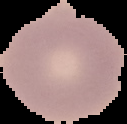

In [54]:
print(trainPaths[0].split(os.path.sep)[-2])
Image.open(trainPaths[0])

training
C45P6ThinF_IMG_20151130_160135_cell_53.png
Uninfected


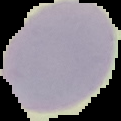

In [53]:
print(datasets[0][0])
print(datasets[0][1][1].split(os.path.sep)[-1])
print(datasets[0][1][1].split(os.path.sep)[-2])
Image.open(datasets[0][1][1])

validation
C103P64ThinF_IMG_20150918_165016_cell_159.png
Parasitized


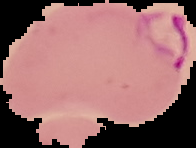

In [55]:
print(datasets[1][0])
print(datasets[1][1][1].split(os.path.sep)[-1])
print(datasets[1][1][1].split(os.path.sep)[-2])
Image.open(datasets[1][1][1])

testing
C146P107ThinF_IMG_20151018_140044_cell_71.png
Uninfected


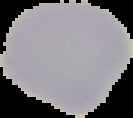

In [56]:
print(datasets[2][0])
print(datasets[2][1][1].split(os.path.sep)[-1])
print(datasets[2][1][1].split(os.path.sep)[-2])
Image.open(datasets[2][1][1])

resnet.py : 사용할 ResNet 모델
- https://towardsdatascience.com/review-resnet-winner-of-ilsvrc-2015-image-classification-localization-detection-e39402bfa5d8

  Review: ResNet — Winner of ILSVRC 2015 (Image Classification, Localization, Detection)

  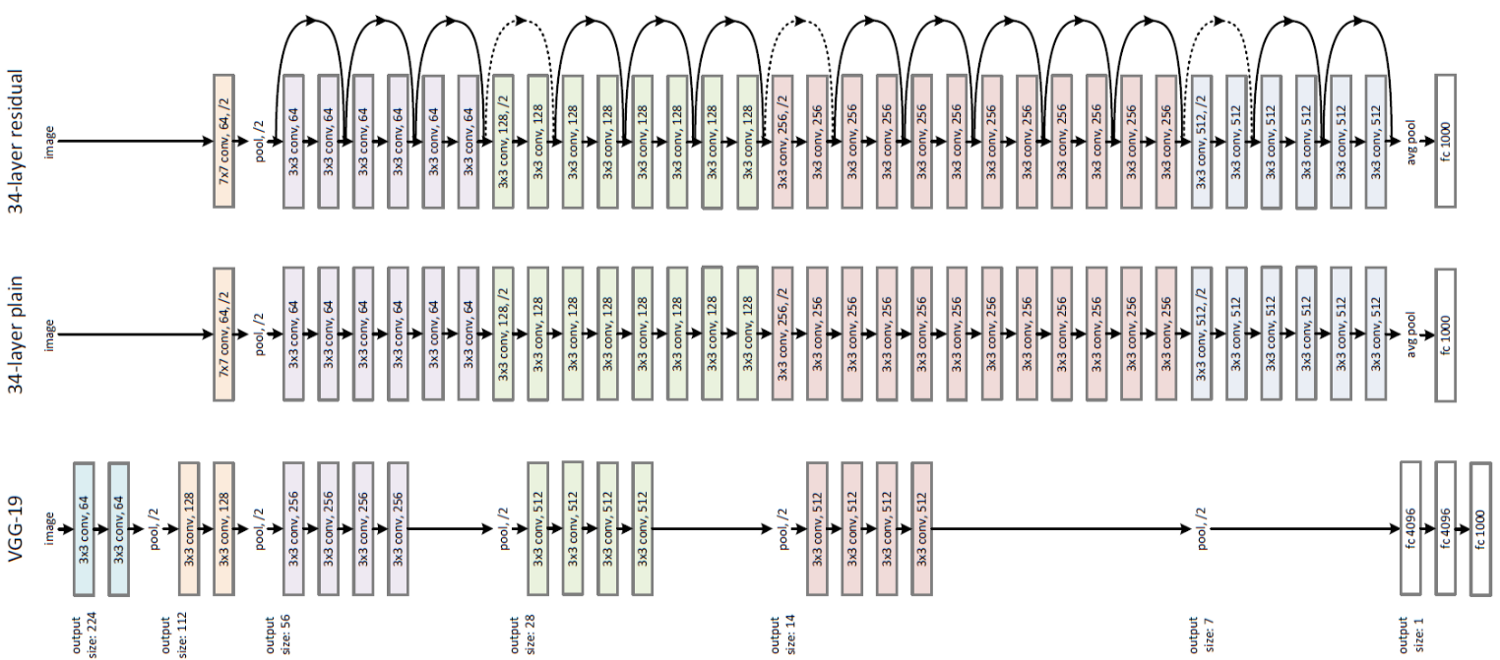

The above figure shows the ResNet architecture.

1. The VGG-19 (bottom) is a state-of-the-art approach in ILSVRC 2014.

2. 34-layer plain network (middle) is treated as the deeper network of VGG-19, i.e. more conv layers.

3. 34-layer residual network (ResNet) (top) is the plain one with addition of skip / shortcut connection.

- For ResNet, there are 3 types of skip / shortcut connections when the input dimensions are smaller than the output dimensions.
  
  (A) Shortcut performs identity mapping, with extra zero padding for increasing dimensions. Thus, no extra parameters.

  (B) The projection shortcut is used for increasing dimensions only, the other shortcuts are identity. Extra parameters are needed.
  
  (C) All shortcuts are projections. Extra parameters are more than that of (B).

In [57]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [12]:
class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# apply CONV => BN => ACT => POOL to reduce spatial size
		x = Conv2D(filters[0], (5, 5), use_bias=False,
			padding="same", kernel_regularizer=l2(reg))(x)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = ZeroPadding2D((1, 1))(x)
		x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

train_model.py : Keras와 ResNet 모델을 사용하여 조직화 된 데이터를 사용하여 말라리아 분류기를 훈련

In [13]:
# 수치를 백그라운드에 저장할 수 있도록 matplotlib 백엔드를 설정
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse

https://stackoverflow.com/questions/48796169/how-to-fix-ipykernel-launcher-py-error-unrecognized-arguments-in-jupyter

In [14]:
# 인수 파서를 구성하고 인수를 구문 분석
# construct the argument parser and parse the arguments
parser = argparse.ArgumentParser()
parser.add_argument("-p", "--plot", type=str, default="plot.png", help="path to output loss/accuracy plot")
args = vars(parser.parse_args(args=[]))

In [15]:
# 훈련 할 총 epoch 수, 초기 학습률 및 배치 크기를 정의
# define the total number of epochs to train for along with the initial learning rate and batch size
NUM_EPOCHS = 50
INIT_LR = 1e-1
BS = 32

def poly_decay(epoch):
  # 최대 epoch 수, 기본 학습률 초기화, 다항식의 거듭 제곱
	# initialize the maximum number of epochs, base learning rate, and power of the polynomial
	maxEpochs = NUM_EPOCHS
	baseLR = INIT_LR
	power = 1.0

  # 다항식 붕괴를 기반으로 새로운 학습률 계산
	# compute the new learning rate based on polynomial decay
	alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power

  # 새로운 학습률을 반환
	# return the new learning rate
	return alpha

In [16]:
# 훈련, 유효성 검사및 테스트 디렉토리에서 이미지 경로의 총 수를 결정
# determine the total number of image paths in training, validation, and testing directories
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

In [17]:
# 훈련 훈련 데이터 증강 객체 초기화
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.05,
	horizontal_flip=True,
	fill_mode="nearest")

# 검증 (및 테스트) 데이터 증가 객체 초기화
# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [18]:
# 훈련 생성기 초기화
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS)

# 검증 생성기 초기화
# initialize the validation generator
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

# 테스트 생성기 초기화
# initialize the testing generator
testGen = valAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(64, 64),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 19842 images belonging to 2 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [19]:
# ResNet 모델을 초기화하고 컴파일합니다.
# initialize our ResNet model and compile it
model = ResNet.build(64, 64, 3, 2, (3, 4, 6),
	(64, 128, 256, 512), reg=0.0005)
opt = SGD(lr=INIT_LR, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [20]:
# 콜백 세트를 정의하고 모델에 적합
# define our set of callbacks and fit the model
callbacks = [LearningRateScheduler(poly_decay)]
H = model.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // BS,
	validation_data=valGen,
	validation_steps=totalVal // BS,
	epochs=NUM_EPOCHS,
	callbacks=callbacks)

Epoch 1/50
620/620 [==============================] - 80s 129ms/step - loss: 1.0722 - accuracy: 0.8477 - val_loss: 0.7677 - val_accuracy: 0.9536
Epoch 2/50
620/620 [==============================] - 77s 125ms/step - loss: 0.7104 - accuracy: 0.9458 - val_loss: 0.6232 - val_accuracy: 0.9522
Epoch 3/50
620/620 [==============================] - 78s 126ms/step - loss: 0.5627 - accuracy: 0.9484 - val_loss: 0.4840 - val_accuracy: 0.9536
Epoch 4/50
620/620 [==============================] - 89s 144ms/step - loss: 0.4626 - accuracy: 0.9522 - val_loss: 0.4182 - val_accuracy: 0.9568
Epoch 5/50
620/620 [==============================] - 77s 124ms/step - loss: 0.6697 - accuracy: 0.9271 - val_loss: 0.5790 - val_accuracy: 0.9531
Epoch 6/50
620/620 [==============================] - 76s 122ms/step - loss: 0.4889 - accuracy: 0.9485 - val_loss: 0.4018 - val_accuracy: 0.9499
Epoch 7/50
620/620 [==============================] - 76s 123ms/step - loss: 0.3644 - accuracy: 0.9524 - val_loss: 0.3193 - val_ac

In [21]:
# 테스트 생성기를 재설정 한 다음 훈련 된 모델을 사용하여 데이터에 대한 예측
# reset the testing generator and then use our trained model to make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict(x=testGen, steps=(totalTest // BS) + 1)

# 테스트 세트의 각 이미지에 대해 해당하는 가장 큰 예측 확률이 있는 레이블의 인덱스를 찾음
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# 멋진 형식의 분류 보고서를 보여줍니다.
# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))

[INFO] evaluating network...
              precision    recall  f1-score   support

 Parasitized       0.98      0.97      0.97      2726
  Uninfected       0.97      0.98      0.98      2786

    accuracy                           0.97      5512
   macro avg       0.97      0.97      0.97      5512
weighted avg       0.97      0.97      0.97      5512



In [22]:
# 훈련 손실과 정확도를 플로팅
# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

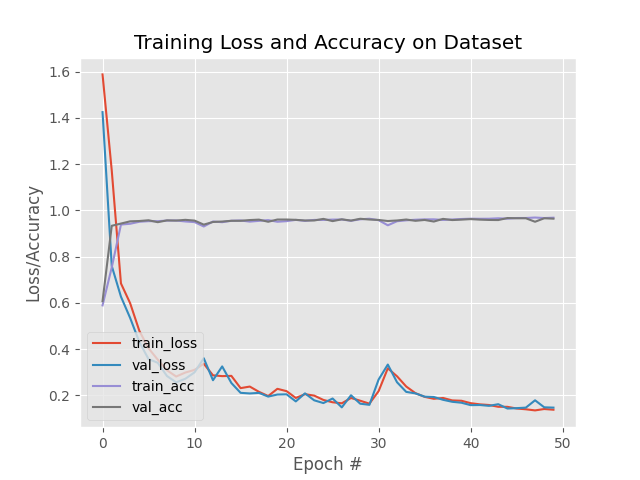

### NIH 데이터 논문(2018)
- https://lhncbc.nlm.nih.gov/system/files/pub9752.pdf
- https://peerj.com/articles/4568/
- https://peerj.com/articles/4568/#supplemental-information



### Malaria Hero 기사 및 github (2018)
- https://github.com/caticoa3/malaria_hero
- https://blog.insightdatascience.com/https-blog-insightdatascience-com-malaria-hero-a47d3d5fc4bb

### cellphone 으로 PBS 현미경 사진 찍어서 분석 (2018)
- https://towardsdatascience.com/diagnose-malaria-from-cellphone-captured-microscopic-images-using-fastai-library-and-turicreate-ae0e27d579e6

### Automated laboratory diagnostics
- http://air.ug/microscopy/